In [1]:
from PIL import Image
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from skimage.util import img_as_ubyte
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, MSELoss, Sigmoid, ConvTranspose2d, Upsample, GELU, BCELoss
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.io import read_image
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor, Compose
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from torchsummary import summary

import matplotlib.pyplot as plt
height, width = 200, 200

In [2]:
# check if we have GPU!

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:

device

device(type='cuda', index=0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
os.listdir("drive/Shareddrives/mvi")

['data.zip',
 'checkpoints',
 'models',
 'NI-MVI_SW.ipynb',
 'Kopie sešitu NI-MVI_SW_RGB.ipynb',
 'NI-MVI_SW_RGB.ipynb',
 'NI-MVI_SW_Diff.ipynb']

In [6]:
! unzip drive/Shareddrives/mvi/data.zip

Výstupní stream byl oříznut na posledních 5000 řádků.
  inflating: grey_images/gustave-courbet_riverside.jpg  
  inflating: grey_images/cubismo_87.jpg  
  inflating: grey_images/childe-hassam_evening.jpg  
  inflating: grey_images/alfred-sisley_the-road-from-hampton-court-1874.jpg  
  inflating: grey_images/cubismo_1.jpg  
  inflating: grey_images/childe-hassam_old-lyme-bridge.jpg  
  inflating: grey_images/pierre-bonnard_dauphine-landscape.jpg  
  inflating: grey_images/portrait-of-giovanni-arnolfini-1435.jpg  
  inflating: grey_images/vincent-van-gogh_the-bois-de-boulogne-with-people-walking-1886.jpg  
  inflating: grey_images/frederic-bazille_the-little-gardener.jpg  
  inflating: grey_images/a-scene-on-the-bridge-and-beld-1.jpg  
  inflating: grey_images/camille-pissarro_the-church-and-farm-of-eragny-1895.jpg  
  inflating: grey_images/maximilien-luce_landscape.jpg  
  inflating: grey_images/claude-monet_river-thawing-near-vetheuil.jpg  
  inflating: grey_images/romantis_80.jpg  
 

In [7]:
os.listdir()

['.config', 'grey_images', 'dataset', 'drive', 'sample_data']

In [8]:
os.listdir("dataset")

['berthe-morisot_snowy-landscape-aka-frost.jpg',
 'claude-monet_autumn-effect-at-argenteuil-1873.jpg',
 'berthe-morisot_thatched-cottage-in-normandy.jpg',
 'wassily-kandinsky_winter-landscape-1909.jpg',
 'john-singer-sargent_a-garden-in-corfu-1909.jpg',
 'paul-signac_samois-study-nr-8-1899.jpg',
 'portrait-of-a-young-girl.jpg',
 'alfred-sisley_footpath-in-the-gardens-at-by.jpg',
 'woman-with-a-blue-blouse-1883.jpg',
 'valentin-serov_autumn-evening-domotkanovo-1886.jpg',
 'expressionismo_293.jpg',
 'pierre-auguste-renoir_view-close-to-antibes.jpg',
 'gustave-caillebotte_the-wall-of-the-kitchen-garden-yerres.jpg',
 'lesser-ury_h-user-am-fluss-mit-einer-waschenden-frau-1894.jpg',
 'portrait-of-the-artist.jpg',
 'eugene-boudin_the-canal-at-saint-valery-sur-somme-1891.jpg',
 'gustave-loiseau_quay-at-dieppe-1905.jpg',
 'childe-hassam_newfields-new-hampshire-1.jpg',
 'vincent-van-gogh_houses-in-auvers-1890.jpg',
 'georges-seurat_landscape-at-saint-ouen-1879.jpg',
 'eugene-boudin_fervaques-gar

In [5]:
class ImageDataset(Dataset):
    def __init__(self, list_names, color_img_dir, grey_img_dir, transform=None, target_transform=None):
        self.img_names = list_names
        self.color_img_dir = color_img_dir
        self.grey_img_dir = grey_img_dir
        self.transform=transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        color_img_path = os.path.join(self.color_img_dir, self.img_names[idx])
        grey_img_path = os.path.join(self.grey_img_dir, self.img_names[idx])
        color_image = Image.open(color_img_path).resize((height, width))
        grey_image = Image.open(grey_img_path).resize((height, width))
        if self.transform:
            color_img = self.transform(color_image)
            grey_img = self.transform(grey_image)
        return grey_img, color_img

In [6]:
df = ImageDataset(os.listdir("./dataset"), "dataset", "grey_images", ToTensor())

In [7]:
data_loader = DataLoader(df, batch_size=16, shuffle=True)

torch.Size([1, 200, 200])
torch.Size([3, 200, 200])


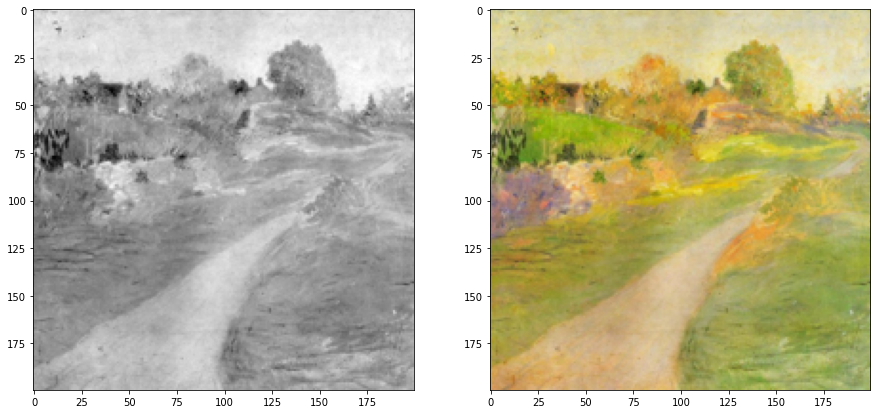

In [8]:
grey_img, color_img = next(iter(data_loader))

print(grey_img[0].shape)
print(color_img[0].shape)
f, axarr = plt.subplots(1,2, figsize=(15, 15))
axarr[0].imshow(grey_img[0].numpy()[0], cmap='gray')
axarr[1].imshow(np.transpose(color_img[0].numpy(), (1,2,0)))

plt.show()

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(os.listdir("./dataset"), np.zeros(len(os.listdir("./dataset"))), test_size=0.35, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(os.listdir("./dataset")[3442:], np.zeros(3441), test_size=0.35, random_state=42)

In [10]:
X_test, X_val, y_test, y_val = train_test_split(X_test, np.zeros(len(X_test)), test_size=0.6, random_state=42)

In [11]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

2236
723
482


In [12]:
train_data = ImageDataset(X_train, "dataset", "grey_images", ToTensor())
val_data = ImageDataset(X_val, "dataset", "grey_images", ToTensor())
test_data = ImageDataset(X_test, "dataset", "grey_images", ToTensor())


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# 1.) CNN

In [13]:
PATH = "drive/Shareddrives/mvi/"

In [14]:
def checkpoints(num_epochs, model_name, model, optimizer):
  i = 1

  for x in range(1, num_epochs):
    if os.path.exists( PATH + "checkpoints/" + model_name + str(x)):
      if os.path.exists(PATH + "checkpoints/" + model_name + str(x + 1)):
        i += 1
        continue
      else:
        checkpoint = torch.load(PATH + "checkpoints/" + model_name + str(x))
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        i += 1
    else:
      break

  return i

In [ ]:
# PyTorch models inherit from torch.nn.Module
class CNN(Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = Conv2d(1, 64, 3, stride=1, padding=1)
    self.bn1 = BatchNorm2d(64)
    self.conv2 = Conv2d(64, 128, 3, stride=1, padding=1)
    self.bn2 = BatchNorm2d(128)
    self.conv3 = Conv2d(128, 256, 3, stride=1, padding=1)
    self.bn3 = BatchNorm2d(256)
    self.conv4 = Conv2d(256, 128, 3, stride=1, padding=1)
    self.conv5 = Conv2d(128, 64, 3, stride=1, padding=1)
    self.conv6 = Conv2d(64, 3, 3, stride=1, padding=1)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = self.conv6(x)
    return x

In [ ]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0

    model.zero_grad() # set the gradients to zero because PyTorch accumulates the gradients

    for i, (data, target) in enumerate(train_loader):      
        
        data, target = data.to(device), target.to(device) #send to GPU

        output = model(data)

        # Compute the loss and its gradients
        loss = criterion(output, target)
    
        train_loss += loss.item()
        
        loss.backward() # calculate backpropagation path
        optimizer.step() # take a step on the loss surface
        model.zero_grad()

    train_loss /= len(train_loader)

    return train_loss

In [ ]:
def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, target in test_loader:
        
            data, target = data.to(device), target.to(device) #send to GPU
            
            output = model(data)
            
            test_loss += criterion(output, target).item()

    test_loss /= len(test_loader)

    return test_loss

In [ ]:
cnn = CNN().to(device)

cnn_opt = Adam(cnn.parameters(), lr=0.0001, weight_decay=1e-5)

cnn_crit = MSELoss()

In [ ]:
num_epochs = 100
train_loss_output = []
val_loss_output = []

i = checkpoints(num_epochs, "cnn/cnn3_", cnn, cnn_opt)
print(i)

100


In [ ]:
for epoch in range(i, num_epochs + 1):
    tr_loss = train(model=cnn,
                    train_loader=train_loader,
                    optimizer=cnn_opt, 
                    criterion=cnn_crit)
    vl_loss = test(cnn, val_loader, cnn_crit)
    print("Epoch:", epoch)
    print("train loss:", tr_loss)
    print("val loss:", vl_loss)
    print()
    train_loss_output.append(tr_loss)
    val_loss_output.append(vl_loss)

    torch.save({
        "epoch": epoch,
        "model_state_dict": cnn.state_dict(),
        "optimizer_state_dict": cnn_opt.state_dict(), 
        "loss": tr_loss,
    }, PATH + "checkpoints/" + "cnn/cnn3_" + str(epoch))
    #val_loss_output.append(vl_loss)

torch.save(cnn.state_dict(), PATH + "models/cnn3")

KeyboardInterrupt: ignored

In [ ]:
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
#cnn.load_state_dict(torch.load(PATH + "models/cnn3"))

In [33]:
def predict(model, test_loader, device):
  grey_img, color_img = next(iter(test_loader))
  grey_img, color_img = grey_img.to(device), color_img.to(device)
  output = model(grey_img)
  return grey_img, output, color_img

In [15]:
def print_images(grey_img, output, color_img):
  f, axarr = plt.subplots(1,3, figsize=(15, 15))
  axarr[0].imshow(grey_img.cpu()[0].numpy()[0], cmap='gray')
  axarr[1].imshow(np.transpose(output.cpu().detach()[0].numpy(), (1, 2, 0)))
  axarr[2].imshow(np.transpose(color_img.cpu()[0].numpy(), (1,2,0)))
  plt.show()

In [ ]:
grey_img, output, color_img = predict(cnn, test_loader, device)

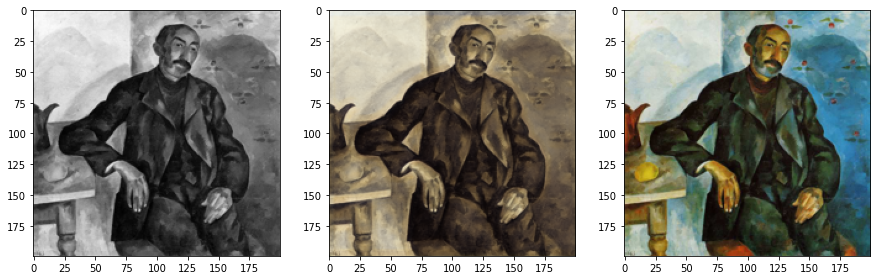

In [ ]:
print_images(grey_img, output, color_img)

## Testing

In [ ]:
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [ ]:
cnn = CNN().to(device)

cnn_opt = Adam(cnn.parameters(), lr=0.0001, weight_decay=1e-5)

cnn_crit = MSELoss()

In [ ]:
cnn.load_state_dict(torch.load(PATH + "models/cnn3"))

<All keys matched successfully>

In [ ]:
test_loss = test(cnn, test_loader, cnn_crit)
print("Test loss for CNN:", test_loss)

Test loss for CNN: 0.0074113506998401135


In [ ]:
print(cnn)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [ ]:
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

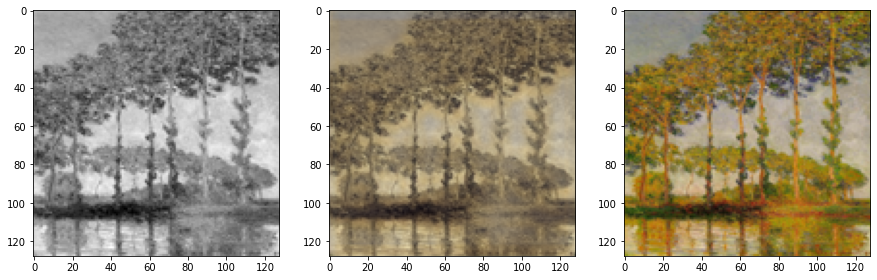

In [ ]:
grey_img, output, color_img = predict(cnn, test_loader, device)
print_images(grey_img, output, color_img)

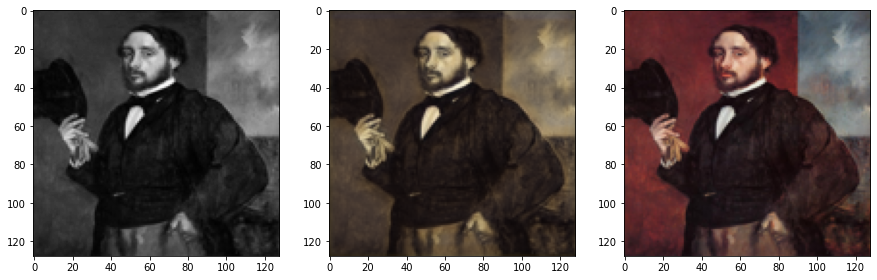

In [ ]:
grey_img, output, color_img = predict(cnn, test_loader, device)
print_images(grey_img, output, color_img)

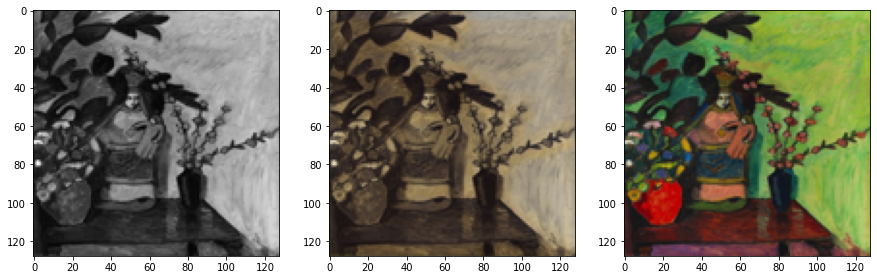

In [ ]:
grey_img, output, color_img = predict(cnn, test_loader, device)
print_images(grey_img, output, color_img)

# 2.) Autoencoder

In [16]:
X_train, X_test, y_train, y_test = train_test_split(os.listdir("./dataset")[3442:], np.zeros(3441), test_size=0.35, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(os.listdir("./dataset"), np.zeros(len(os.listdir("./dataset"))), test_size=0.35, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test, np.zeros(len(X_test)), test_size=0.6, random_state=42)

print(len(X_train))
print(len(X_val))
print(len(X_test))

train_data = ImageDataset(X_train, "dataset", "grey_images", ToTensor())
val_data = ImageDataset(X_val, "dataset", "grey_images", ToTensor())
test_data = ImageDataset(X_test, "dataset", "grey_images", ToTensor())


train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

2236
723
482


In [17]:
class Autoencoder(Module):
  def __init__(self):
    super(Autoencoder, self).__init__()

    #Encoder
    self.conv1 = Conv2d(1, 64, 3, padding=1, stride=2)
    self.conv2 = Conv2d(64, 128, 3, padding=1)
    self.conv3 = Conv2d(128, 128, 3, padding=1, stride=2)
    self.conv4 = Conv2d(128, 256, 3, padding=1)
    self.conv5 = Conv2d(256, 256, 3, padding=1, stride=2)
    self.conv6 = Conv2d(256, 512, 3, padding=1)
    self.conv7 = Conv2d(512, 512, 3, padding=1)
    self.conv8 = Conv2d(512, 256, 3, padding=1)


    # Decoder
    self.tr_conv1 = ConvTranspose2d(256, 128, 2, stride=2)
    self.tr_conv2 = ConvTranspose2d(128, 64, 2, stride=2)
    self.tr_conv3 = ConvTranspose2d(64, 32, 2, stride=2)
    self.tr_conv4 = ConvTranspose2d(32, 16, 2, stride=2)
    self.conv_out = Conv2d(16, 3, 3, padding=1, stride=2)


  def forward(self, x):
    ## Encoder

    x = self.conv1(x)
    x = F.relu(x)

    x = self.conv2(x)
    x = F.relu(x)

    x = self.conv3(x)
    x = F.relu(x)

    x = self.conv4(x)
    x = F.relu(x)

    x = self.conv5(x)
    x = F.relu(x)

    x = self.conv6(x)
    x = F.relu(x)

    x = self.conv7(x)
    x = F.relu(x)

    x = self.conv8(x)
    x = F.relu(x)


    ## Decoder

    x = self.tr_conv1(x)
    x = F.relu(x)

    x = self.tr_conv2(x)
    x = F.relu(x)

    x = self.tr_conv3(x)
    x = F.relu(x)

    x = self.tr_conv4(x)
    x = F.relu(x)

    x = self.conv_out(x)
    x = torch.sigmoid(x)

    return x

In [ ]:
AE = Autoencoder().to(device)
print(AE)

Autoencoder(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (tr_conv1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (tr_conv2): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (tr_conv3): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (tr_conv4): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv_out): Conv2d(16, 3, kernel_size=(3, 3), stride=(2, 2), p

In [18]:
AE_crit = MSELoss()

AE_opt = torch.optim.Adam(AE.parameters(), lr=0.0001, weight_decay=1e-5)

NameError: ignored

In [ ]:
num_epochs = 300
train_loss_output = []
val_loss_output = []

i = checkpoints(num_epochs, "AE_", AE, AE_opt)
print(i)

In [ ]:
for epoch in range(i, num_epochs + 1):
    tr_loss = train(model=AE,
                    train_loader=train_loader,
                    optimizer=AE_opt, 
                    criterion=AE_crit)
    vl_loss = test(AE, val_loader, AE_crit)
    print("Epoch:", epoch)
    print("train loss:", tr_loss)
    print("val loss:", vl_loss)
    print()
    train_loss_output.append(tr_loss)
    val_loss_output.append(vl_loss)

    torch.save({
        "epoch": epoch,
        "model_state_dict": AE.state_dict(),
        "optimizer_state_dict": AE_opt.state_dict(), 
        "loss": tr_loss,
    }, PATH + "checkpoints/" + "AE_" + str(epoch))

torch.save(AE.state_dict(), PATH + "models/AE100")

Epoch: 99
train loss: 0.06390492783652411
val loss: 0.0626819437990586

Epoch: 100
train loss: 0.06347885748578443
val loss: 0.06261821712056796



In [ ]:
AE = Autoencoder()
AE.load_state_dict(torch.load(PATH + "models/AE"))

<All keys matched successfully>

In [ ]:
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
grey_img, output, color_img = predict(AE, test_loader, device)

RuntimeError: ignored

In [ ]:
print_images(grey_img, output, color_img)

## Testing

In [ ]:
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

In [ ]:
AE = Autoencoder().to(device)

AE_crit = MSELoss()

AE_opt = torch.optim.Adam(AE.parameters(), lr=0.0001, weight_decay=1e-5)

In [ ]:
AE.load_state_dict(torch.load(PATH + "models/AE"))

<All keys matched successfully>

In [ ]:
test_loss = test(AE, test_loader, AE_crit)
print("Test loss for AE:", test_loss)

Test loss for AE: 0.00930058560334146


In [ ]:
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

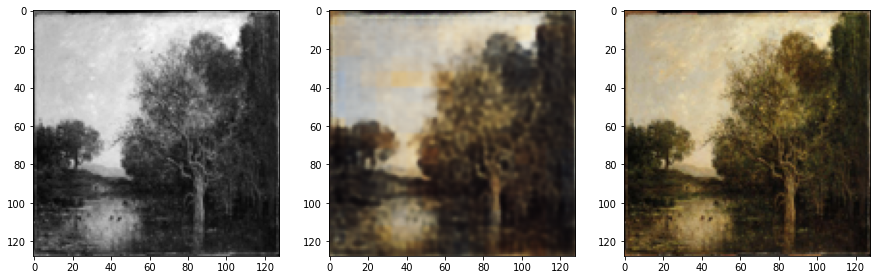

In [ ]:
grey_img, output, color_img = predict(AE, test_loader, device)
print_images(grey_img, output, color_img)

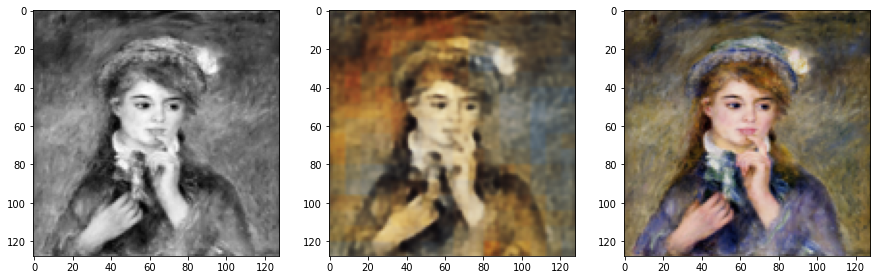

In [ ]:
grey_img, output, color_img = predict(AE, test_loader, device)
print_images(grey_img, output, color_img)

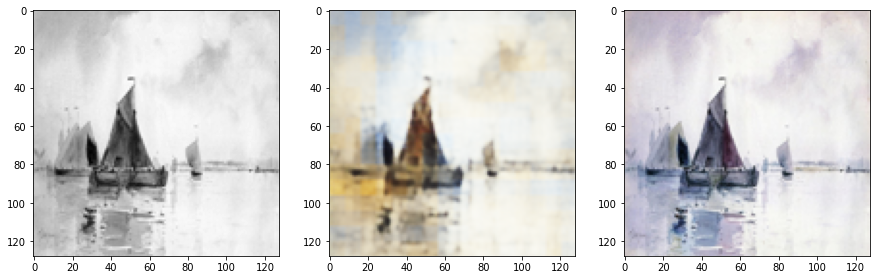

In [ ]:
grey_img, output, color_img = predict(AE, test_loader, device)
print_images(grey_img, output, color_img)

# 3.) VAE

In [16]:
height, width = 128, 128

df = ImageDataset(os.listdir("./dataset"), "dataset", "grey_images", ToTensor())

In [17]:
X_train, X_test, y_train, y_test = train_test_split(os.listdir("./dataset")[3442:], np.zeros(3441), test_size=0.35, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, np.zeros(len(X_test)), test_size=0.6, random_state=42)

In [18]:
train_data = ImageDataset(X_train, "dataset", "grey_images", ToTensor())
val_data = ImageDataset(X_val, "dataset", "grey_images", ToTensor())
test_data = ImageDataset(X_test, "dataset", "grey_images", ToTensor())


train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

In [19]:
# define a VAE
class VAE(Module):
    def __init__(self, h_dim=8192, z_dim=1024):
        super(VAE, self).__init__()
 
        # encoder
        self.conv1 = Conv2d(1, 32, 4, padding=1, stride=2)
        self.conv3 = Conv2d(32, 64, 4, padding=1, stride=2)
        self.conv5 = Conv2d(64, 128, 4, padding=1, stride=2)
        self.conv7 = Conv2d(128, 256, 4, padding=1, stride=2)
        self.conv9 = Conv2d(256, 512, 4, padding=1, stride=2)

        # fully connected layers for learning representations
        self.fc_mu = Linear(h_dim, z_dim)
        self.fc_log_var = Linear(h_dim, z_dim)
        self.fc3 = Linear(z_dim, h_dim)

        # decoder 
        self.tr_conv1 = ConvTranspose2d(h_dim, 256, 8, stride=2)
        self.tr_conv3 = ConvTranspose2d(256, 128, 2, stride=2)
        self.tr_conv5 = ConvTranspose2d(128, 64, 2, stride=2)
        self.tr_conv7 = ConvTranspose2d(64, 32, 2, stride=2)
        self.tr_conv9 = ConvTranspose2d(32, 3, 2, stride=2)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) 
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        z = mu + (std * eps) # sampling
        return z

    def forward(self, x):
        # encoding
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv9(x))

        # flatten x
        x_flatten = x.view(x.size(0), -1)

        # get `mu` and `log_var`
        mu = self.fc_mu(x_flatten)
        log_var = self.fc_log_var(x_flatten)

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)

        # decoding
        z = F.relu(self.fc3(z))
        #print("Z 2", z.shape)
        z = z.view(z.size(0), 8192, 1, 1)
        x = F.relu(self.tr_conv1(z))
        x = F.relu(self.tr_conv3(x))
        x = F.relu(self.tr_conv5(x))
        x = F.relu(self.tr_conv7(x))
        x = torch.sigmoid(self.tr_conv9(x))
        return x, mu, log_var

In [20]:
vae = VAE().to(device)
vae_opt = Adam(vae.parameters(), lr=1e-3)
vae_crit = MSELoss()

In [21]:
print(vae)

VAE(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_mu): Linear(in_features=8192, out_features=1024, bias=True)
  (fc_log_var): Linear(in_features=8192, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=8192, bias=True)
  (tr_conv1): ConvTranspose2d(8192, 256, kernel_size=(8, 8), stride=(2, 2))
  (tr_conv3): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (tr_conv5): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (tr_conv7): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (tr_conv9): ConvTranspose2d(32, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [22]:
def final_loss(recon_loss, mu, logvar, batch_size):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + (KLD / batch_size)

In [23]:
def train_vae(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0

    model.zero_grad() # set the gradients to zero because PyTorch accumulates the gradients

    for i, (data, target) in enumerate(train_loader): 

        data, target = data.to(device), target.to(device) #s end to GPU

        output, mu, logvar = model(data)

        # Compute the loss and its gradients
        recon_loss = criterion(output, target)
        loss = final_loss(recon_loss, mu, logvar, data.shape[0])

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        model.zero_grad()

    train_loss /= len(train_loader)
    return train_loss

In [24]:
def test_vae(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:

            data, target = data.to(device), target.to(device) #send to GPU

            output, mu, logvar = model(data)

            recon_loss = criterion(output, target)
            loss = final_loss(recon_loss, mu, logvar, data.shape[0])

            test_loss += loss.item()

    test_loss /= len(test_loader)

    return test_loss

In [26]:
num_epochs = 100
train_loss_output = []
val_loss_output = []

i = checkpoints(num_epochs, "vae/vae19_", vae, vae_opt)
print(i)

1


In [27]:
for epoch in range(i, num_epochs + 1):
    tr_loss = train_vae(model=vae,
                    train_loader=train_loader,
                    optimizer=vae_opt, 
                    criterion=vae_crit)
    vl_loss = test_vae(vae, val_loader, vae_crit)
    print("Epoch:", epoch)
    print("train loss:", tr_loss)
    print("val loss:", vl_loss)
    print()
    train_loss_output.append(tr_loss)
    val_loss_output.append(vl_loss)

    torch.save({
        "epoch": epoch,
        "model_state_dict": vae.state_dict(),
        "optimizer_state_dict": vae_opt.state_dict(), 
        "loss": tr_loss,
    }, PATH + "checkpoints/vae/" + "vae19_" + str(epoch))

    torch.save(vae.state_dict(), PATH + "models/vae19")

Epoch: 1
train loss: 0.061955018368150504
val loss: 0.058382927156660866

Epoch: 2
train loss: 0.05813099792493241
val loss: 0.05706934817135334

Epoch: 3
train loss: 0.05798076220921108
val loss: 0.05772215208929518

Epoch: 4
train loss: 0.05778663059962647
val loss: 0.057054980617502464

Epoch: 5
train loss: 0.05768593879682677
val loss: 0.056728082263599273

Epoch: 6
train loss: 0.057543876793767726
val loss: 0.057195337732201035

Epoch: 7
train loss: 0.05744373314082622
val loss: 0.05628817528486252

Epoch: 8
train loss: 0.05738279901977096
val loss: 0.055933178200022034

Epoch: 9
train loss: 0.05738571735897235
val loss: 0.05697475511418736

Epoch: 10
train loss: 0.05749025629567248
val loss: 0.0568843231253002

Epoch: 11
train loss: 0.05724933408200741
val loss: 0.05648896211515302

Epoch: 12
train loss: 0.05737560750650508
val loss: 0.05613200002066467



KeyboardInterrupt: ignored

In [81]:
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
#vae.load_state_dict(torch.load(PATH + "models/vae9"))

In [88]:
grey_img, color_img = next(iter(test_loader))

grey_img, color_img = grey_img.to(device), color_img.to(device)

output, mu, logvar = vae(grey_img)

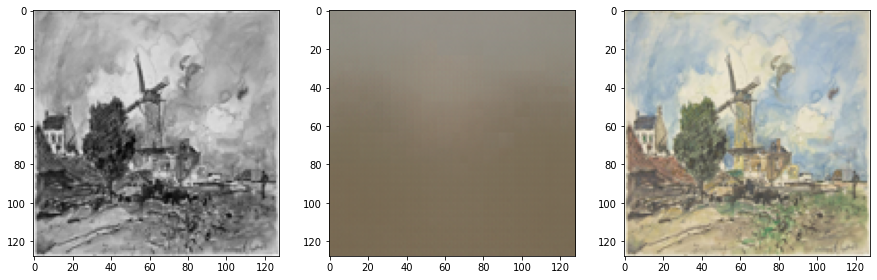

In [86]:
print_images(grey_img, output, color_img)

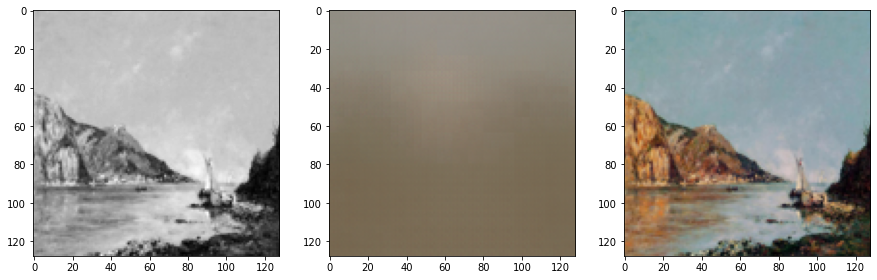

In [84]:
print_images(grey_img, output, color_img)

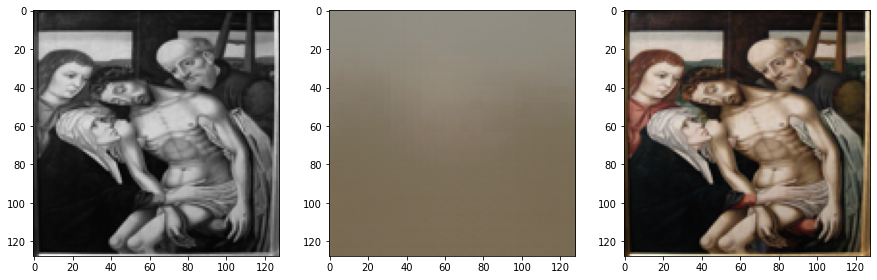

In [89]:
print_images(grey_img, output, color_img)

## Testing

In [28]:
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

In [29]:
vae = VAE().to(device)
vae_opt = Adam(vae.parameters(), lr=1e-3)
vae_crit = MSELoss()

In [30]:
vae.load_state_dict(torch.load(PATH + "models/vae19"))

<All keys matched successfully>

In [31]:
test_loss = test_vae(vae, test_loader, vae_crit)
print("Test loss for VAE:", test_loss)

Test loss for VAE: 0.05755361902617639


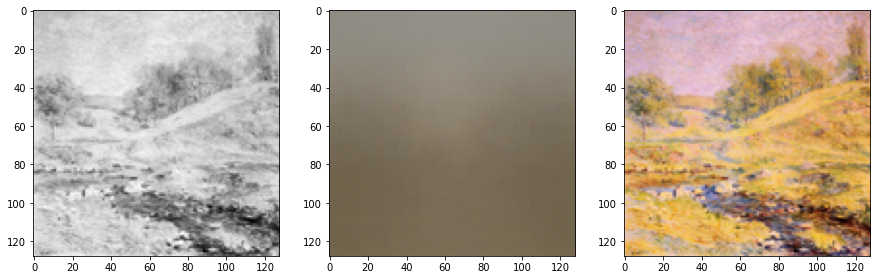

In [32]:
grey_img, color_img = next(iter(test_loader))

grey_img, color_img = grey_img.to(device), color_img.to(device)

output, mu, logvar = vae(grey_img)
print_images(grey_img, output, color_img)